### import packages

python original packages or the third-party packages

In [1]:
import os
from dotenv import load_dotenv
import torch
import numpy as np

personal defined modules in this project

In [2]:
from utils.config_utils import load_ddpm_config, load_dip_config, load_img_config, load_guide_dip_config
from utils.plot_utils import plot_snapshots, plot_sequence, plot_psnr
from utils.image_utils import load_image_to_tensor, pillow2image, compute_psnr_score, compute_ssim_score
from models.model import DDPM, DIP
from train.train_dip import train_dip

### load the config

In [3]:
config_path = "config.yaml"
load_dotenv()
DATA_ENTRY = str(os.getenv("DATA_ENTRY"))

image_path = os.path.join(DATA_ENTRY, "Image_1.jpg")

In [4]:
ddpm_config = load_ddpm_config(config_path)
dip_config = load_dip_config(config_path)
height, width = load_img_config(config_path)

### Test for DDPM and DIP
* the add noise process
* dip train on the target clean image

In [5]:
diffusion = DDPM(**ddpm_config)
target_image = load_image_to_tensor(image_path, height, width)

Start adding noise to the target image in data/test\Image_1.jpg time stamp 10
Start adding noise to the target image in data/test\Image_1.jpg time stamp 46
Start adding noise to the target image in data/test\Image_1.jpg time stamp 82
Start adding noise to the target image in data/test\Image_1.jpg time stamp 118
Start adding noise to the target image in data/test\Image_1.jpg time stamp 155
Start adding noise to the target image in data/test\Image_1.jpg time stamp 191
Start adding noise to the target image in data/test\Image_1.jpg time stamp 227
Start adding noise to the target image in data/test\Image_1.jpg time stamp 263
Start adding noise to the target image in data/test\Image_1.jpg time stamp 300


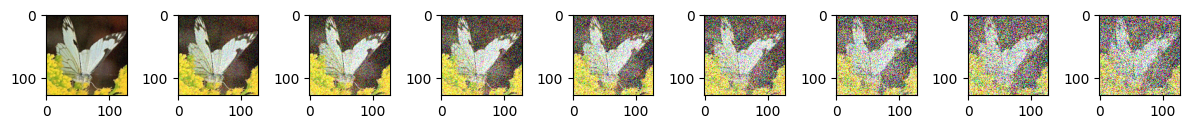

In [6]:
ts = torch.linspace(10, 400, 9)
sequences = []

for t in ts:
    t = int(t.item())
    print(f"Start adding noise to the target image in {image_path} time stamp {t}")
    noisy_image, _ = diffusion.forward_diffusion(target_image, t)
    noisy_image = noisy_image.squeeze(0)
    noisy_image = noisy_image.permute(1,2,0)
    sequences.append( pillow2image(noisy_image) )

plot_sequence(sequences, plot_method="plot")

In [7]:
model = DIP(dip_config["backbone_name"])
print("=============================================================================")
print(model)
print("=============================================================================")
print("The above is the DIP model backbone!!")

DIP(
  (backbone): UNet(
    (leaky_relu): LeakyReLU(negative_slope=0.01)
    (d_conv_1): Conv2d(3, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (d_bn_1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d_conv_2): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (d_bn_2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (d_conv_3): Conv2d(16, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (d_bn_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (s_conv_3): Conv2d(32, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (d_conv_4): Conv2d(32, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (d_bn_4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (s_conv_4): Conv2d(64, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (d_conv_5): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2

#### train the dip on origin image

100%|██████████| 300/300 [00:06<00:00, 43.66it/s]


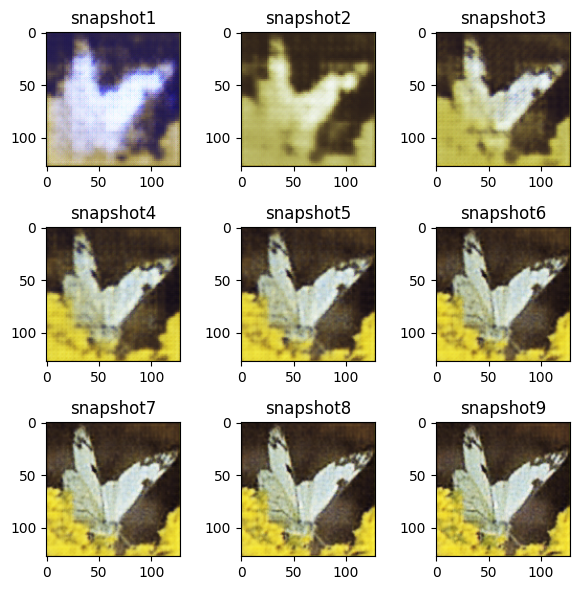

In [8]:
noisy_image, _ = diffusion.forward_diffusion(target_image, 30)
snapshots = train_dip(model, noisy_image, **dip_config)

plot_snapshots(snapshots, plot_method="plot")

### Parameters

training iterations

In [9]:
num_steps = dip_config["num_steps"]

Given $k$ stages of noisy samples and assign different weights of training steps based on its level of noise

$$w_{i}=\frac{i}{1+2+...+k}$$
$$N_{i}=N*w_{i}$$

where $N$ is the total steps of DIP

In [10]:
timestamps = [ int(i) for i in np.linspace(10, 300, ) ]
weights = np.arange(1, len(timestamps)+1)
weights = weights / np.sum(weights)

print(f"each noise weights: {weights}")

steps = [ int(num_steps * w) for w in weights[:-1] ]
steps.append( num_steps - np.sum(steps) )

print(f"each noisy image train steps: {steps}")

each noise weights: [0.02222222 0.04444444 0.06666667 0.08888889 0.11111111 0.13333333
 0.15555556 0.17777778 0.2       ]
each noisy image train steps: [6, 13, 20, 26, 33, 40, 46, 53, 63]


### Train DIP with the image with small noise

100%|██████████| 300/300 [00:07<00:00, 41.18it/s]


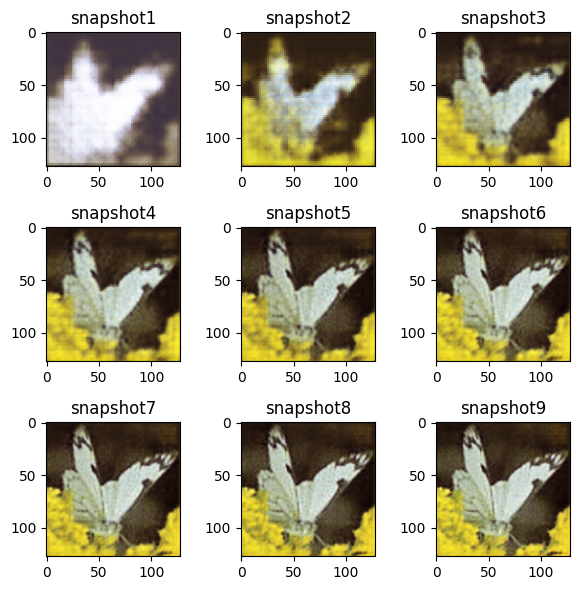

In [11]:
clean_image = load_image_to_tensor(image_path, height, width)
target_image, _ = diffusion.forward_diffusion(clean_image, timestamps[0])

model = DIP(dip_config["backbone_name"])

snapshots, psnrs = train_dip(model, target_image, **dip_config)
plot_snapshots(snapshots, plot_method="plot")

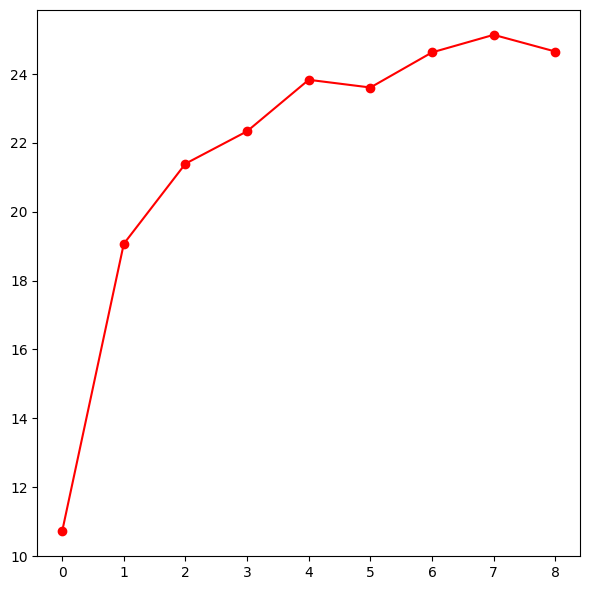

In [12]:
plot_psnr(psnrs)